{0: {'median': np.float64(0.0069797891192138195), 'p90': np.float64(0.0243440646678214), 'frac': {0.02: 0.8684210526315791, 0.05: 0.9671052631578949, 0.1: 0.9934210526315791}, 'n': 456}, 1: {'median': np.float64(0.013489943891242686), 'p90': np.float64(0.04801121801137924), 'frac': {0.02: 0.6308459084774873, 0.05: 0.9116826156299842, 0.1: 0.9903508771929824}, 'n': 300}, 2: {'median': np.float64(0.01934277825057502), 'p90': np.float64(0.060600943863393215), 'frac': {0.02: 0.5247747747747747, 0.05: 0.8626126126126128, 0.1: 0.9639639639639641}, 'n': 444}}
[cone] geom-fair median=0.007, p90=0.024
[cuboid] geom-fair median=0.013, p90=0.048
[cylinder] geom-fair median=0.019, p90=0.061


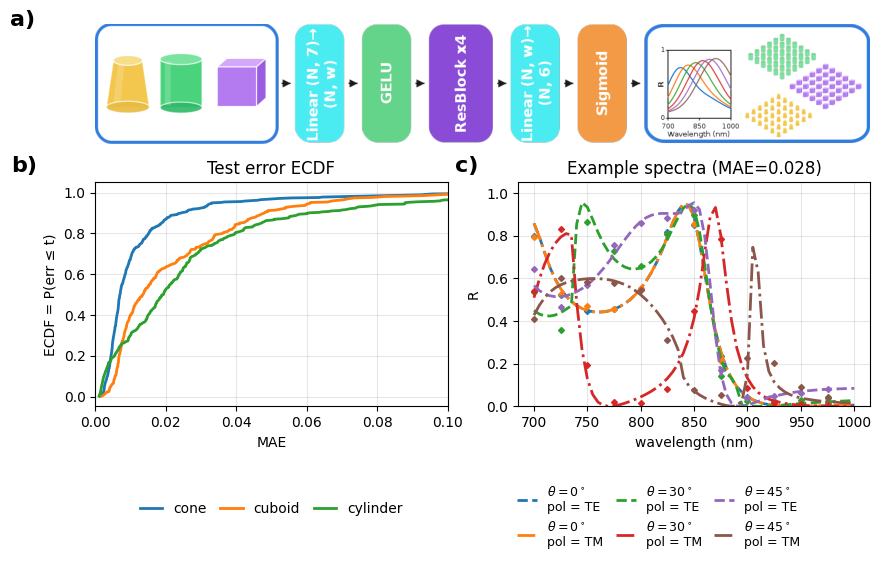

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io


def plot_spectra_for_gid(
    ax, gid, te_gid, wl_te,
    R_true_te, R_pred_te,
    *,
    R_ref,
    wl_ref,
    angles=None,
    ang_ids=(0, 1, 2),
    n_angles=3,
    n_pols=2,
    pol_ids=(0,),
    title="",
    ylim=(0, 1.05),
):
    m = (te_gid == gid)

    w  = np.asarray(wl_te[m])
    Rt = R_ref
    Rp = np.asarray(R_pred_te[m])

    if Rt.ndim == 2 and Rt.shape[1] == n_angles * n_pols:
        Rt = Rt.reshape(Rt.shape[0], n_angles, n_pols)
        Rp = Rp.reshape(Rp.shape[0], n_angles, n_pols)
    elif Rt.ndim == 2 and Rt.shape[1] == n_angles and n_pols == 1:
        Rt = Rt[:, :, None]
        Rp = Rp[:, :, None]
    else:
        raise ValueError(f"Unexpected Rt shape {Rt.shape}; expected [npts,{n_angles*n_pols}]")

    pol_styles = {"TM": "-.", "TE": "--"}
    for j in ang_ids:
        for p in pol_ids:
            pstr = "TM" if p == 1 else "TE"
            lab = "\n".join([fr"$\theta={angles[j]*180/np.pi:.0f}^\circ$", f"pol = {pstr}"])
            (ln,) = ax.plot(wl_ref, Rt[:, j, p], pol_styles.get(pstr, "--"), ms=6, lw=2., label=lab)
            c = ln.get_color()
            ax.plot(w, Rp[:, j, p], marker="D", color=c, ms=3, linestyle="None")

    ax.set_xlabel("wavelength (nm)")
    ax.set_ylabel("R")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    if ylim is not None:
        ax.set_ylim(*ylim)

def weighted_ecdf(x, w):
    x = np.asarray(x).ravel()
    w = np.asarray(w).ravel()
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    order = np.argsort(x)
    xs = x[order]
    ws = w[order]
    cdf = np.cumsum(ws) / np.sum(ws)
    return xs, cdf


def geom_fair_weights(gid):
    gid = np.asarray(gid).ravel()
    uniq, counts = np.unique(gid, return_counts=True)
    cdict = dict(zip(uniq, counts))
    return np.array([1.0 / cdict[g] for g in gid], dtype=float)


def weighted_quantile(x, w, qs):
    x = np.asarray(x).ravel()
    w = np.asarray(w).ravel()
    m = np.isfinite(x) & np.isfinite(w) & (w > 0)
    x, w = x[m], w[m]
    order = np.argsort(x)
    x, w = x[order], w[order]
    cw = np.cumsum(w) / np.sum(w)
    return np.interp(qs, cw, x)


def summarize_by_class(err, y, gid, thresholds=(0.02, 0.05, 0.10)):
    err = np.asarray(err).ravel()
    y   = np.asarray(y).ravel().astype(int)
    gid = np.asarray(gid).ravel()
    w_all = geom_fair_weights(gid)

    out = {}
    for c in np.unique(y):
        m = (y == c)
        q50, q90 = weighted_quantile(err[m], w_all[m], [0.5, 0.9])
        fracs = {t: float(np.sum(w_all[m][err[m] <= t]) / np.sum(w_all[m])) for t in thresholds}
        out[int(c)] = dict(median=q50, p90=q90, frac=fracs, n=int(m.sum()))
    return out


def plot_weighted_cdf_by_class(err, labels, gids, class_ids=None, class_names=None,
                               ax=None, title=" CDF (test set)",
                               xlabel="error", logx=False):
    err = np.asarray(err).ravel()
    labels = np.asarray(labels).ravel().astype(int)
    gids = np.asarray(gids).ravel()

    w_all = geom_fair_weights(gids)

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    if class_ids is None:
        class_ids = np.unique(labels)

    for cid in class_ids:
        m = labels == cid
        if m.sum() == 0:
            continue

        xs, cdf = weighted_ecdf(err[m], w_all[m])
        q50, q90 = np.interp([0.5, 0.9], cdf, xs)

        if class_names is None:
            name = str(int(cid))
        else:
            name = str(class_names[int(cid)])

        print(f"[{name}] geom-fair median={q50:.3f}, p90={q90:.3f}")
        ax.plot(xs, cdf, lw=2, label=name)
        
    ax.set_xlim(0, 0.1)
    if logx:
        ax.set_xscale("log")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("ECDF = P(err ≤ t)")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    return ax


def make_paper_fig(
    err_sample,
    y_te, te_gid, wl_te,
    R_true_te, R_pred_te,
    *,
    R_ref, wl_ref,
    gid_spec,
    class_names=None,
    angles=None,
    ang_ids=(0, 1, 2),
    pol_ids=None,
    logx_cdf=False,
    savepath="figure_5.png",
    top_png_path=None,
    figsize=(10.0, 5.),
    label_top="a)",
    label_cdf="b)",
    label_spec="c)",
):
    has_top = top_png_path is not None

    if has_top:
        fig = plt.figure(figsize=figsize)
        img = mpimg.imread(top_png_path)
        H, W = img.shape[:2]
        img_aspect = H / W
        wsize = figsize[0]
        hsize = figsize[1]
        thsize = img_aspect*wsize
        hspace = 0.2
        wspace = 0.2
        bhsize = hsize - thsize - hspace - 0.5

        gs = fig.add_gridspec(
            2, 2,
            height_ratios=[thsize, bhsize],
            width_ratios=[1., 1.],
            hspace=hspace, wspace=wspace
        )
        ax_top  = fig.add_subplot(gs[0, :])
        ax_cdf  = fig.add_subplot(gs[1, 0])
        ax_spec = fig.add_subplot(gs[1, 1])

        ax_top.imshow(img)
        ax_top.set_axis_off()
        ax_top.text(
            -0.11, 1.12, label_top,
            transform=ax_top.transAxes,
            ha="left", va="top",
            fontsize=16, fontweight="bold",
            color="k"
        )
    else:
        fig = plt.figure(figsize=(10.0, 3.5))
        gs = fig.add_gridspec(
            1, 2,
            width_ratios=[1.0, 1.1],
            wspace=0.25,
        )
        ax_cdf  = fig.add_subplot(gs[0, 0])
        ax_spec = fig.add_subplot(gs[0, 1])

    stats = summarize_by_class(err_sample, y_te, te_gid)
    print(stats)
    plot_weighted_cdf_by_class(
        err=err_sample,
        labels=y_te,
        gids=te_gid,
        ax=ax_cdf,
        class_ids=np.unique(y_te),
        class_names=class_names,
        logx=logx_cdf,
        xlabel="MAE",
        title="Test error ECDF",
    )
    ax_cdf.text(
        -0.24, 1.12, label_cdf,
        transform=ax_cdf.transAxes,
        fontsize=16, fontweight="bold",
        va="top", ha="left"
    )

    m = (te_gid == gid_spec)
    mae_g = float(np.mean(np.abs(R_pred_te[m] - R_true_te[m])))

    if pol_ids is None:
        pol_ids = (0, 1)

    h, lab = ax_cdf.get_legend_handles_labels()
    if len(h):
        ax_cdf.legend(
            h, lab,
            loc="upper center",
            bbox_to_anchor=(0.5, -0.4),
            ncol=min(3, len(h)),
            frameon=False,
            columnspacing=1.0,
            handlelength=1.6,
            borderaxespad=0.0,
        )

    plot_spectra_for_gid(
        ax_spec, gid_spec, te_gid, wl_te,
        R_true_te, R_pred_te, R_ref=R_ref, wl_ref=wl_ref,
        angles=angles, ang_ids=ang_ids,
        n_angles=len(angles) if angles is not None else len(ang_ids),
        n_pols=len(pol_ids),
        pol_ids=pol_ids,
        title=f"Example spectra (MAE={mae_g:.3f})",
        ylim=(0, 1.05),
    )
    ax_spec.text(
        -0.18, 1.12, label_spec,
        transform=ax_spec.transAxes,
        fontsize=16, fontweight="bold",
        va="top", ha="left"
    )

    handles, labels = ax_spec.get_legend_handles_labels()
    ax_spec.legend(
        handles, labels,
        loc="upper center",
        bbox_to_anchor=(0.4, -0.3),
        #bbox_to_anchor=(0.4, -1.6),
        ncol=3,
        frameon=False,
        fontsize=9,
        columnspacing=1.0,
        handlelength=1.6,
    )

    fig.savefig(savepath, dpi=300, bbox_inches="tight")
    return fig


def load_paper_fig_h5(path):
    with h5py.File(path, "r") as f:
        d = {k: f[k][...] for k in f.keys() if k != "top_png_bytes"}

        def decode_arr(a):
            if a.dtype.kind in ("S", "O"):
                return np.array([x.decode("utf-8") if isinstance(x, (bytes, np.bytes_)) else str(x) for x in a])
            return a

        d["te_gid"]      = decode_arr(d["te_gid"])
        d["class_names"] = decode_arr(d["class_names"]).tolist()
        d["gid_spec"]    = decode_arr(d["gid_spec"])[0]

        if "top_png_bytes" in f:
            png_bytes = f["top_png_bytes"][...].tobytes()
            d["top_img"] = mpimg.imread(io.BytesIO(png_bytes))
        else:
            d["top_img"] = None

    return d


h5path = "results/paramtor_results.h5"
d = load_paper_fig_h5(h5path)

top_path = "figs/ptor.png"
fig = make_paper_fig(
    err_sample=d["err_sample"],
    y_te=d["y_te"],
    te_gid=d["te_gid"],
    wl_te=d["wl_te"],
    R_true_te=d["R_true_te"],
    R_pred_te=d["R_pred_te"],
    R_ref=d["R_ref"],
    wl_ref=d["wl_ref"],
    angles=d["angles"],
    class_names=d["class_names"],
    ang_ids=d["ang_ids"],
    pol_ids=d["pol_ids"],
    gid_spec=d["gid_spec"],
    top_png_path=top_path,
    savepath="figs/figure_5.png",
)
